In [1]:
import torch
import torch.nn.functional as F
from torchvision import models,transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def preprocess(path,size):
    prep = transforms.Compose([transforms.Resize(size),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
    image = Image.open(path).convert("RGB")
    return prep(image).unsqueeze(0)
def show_cam_on_image(image,mask):
    mask = cv2.resize(mask,(image.shape[1],image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*mask),cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255*cam)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hoo

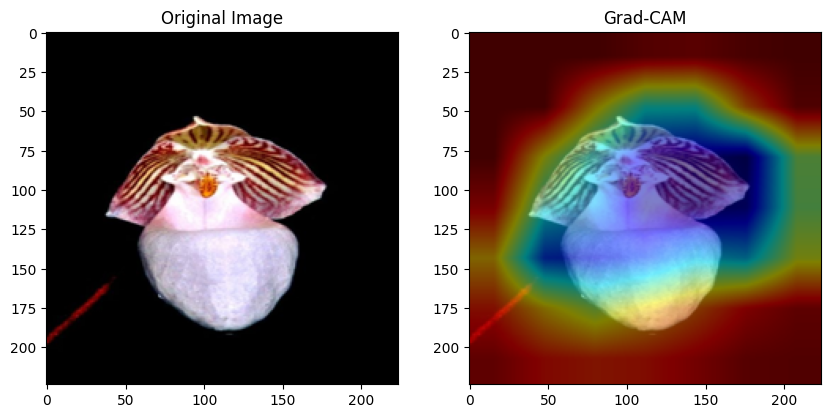

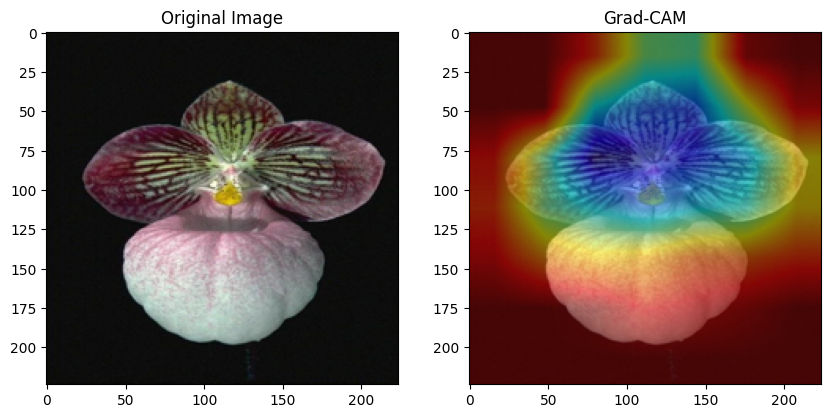

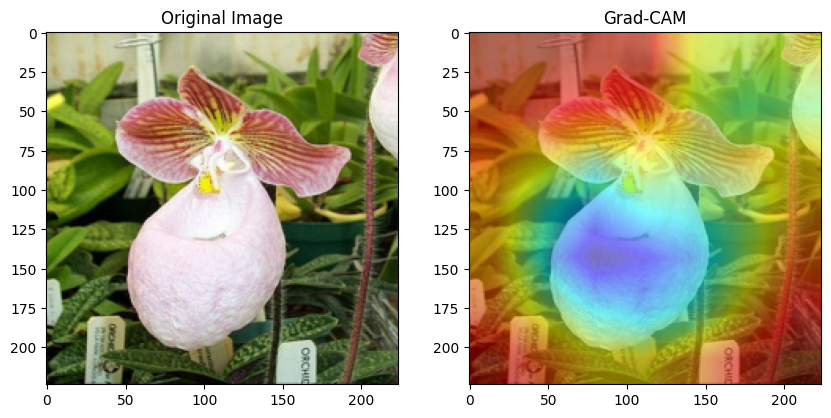

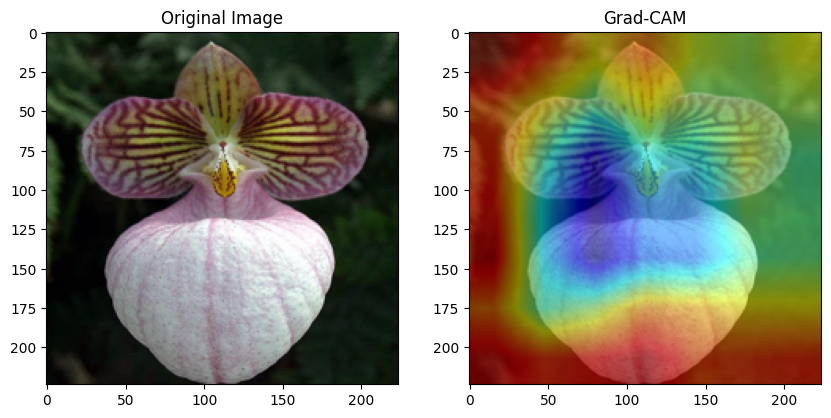

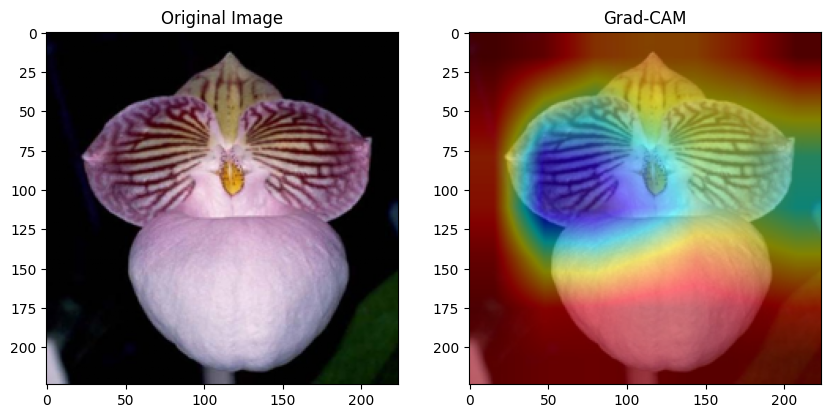

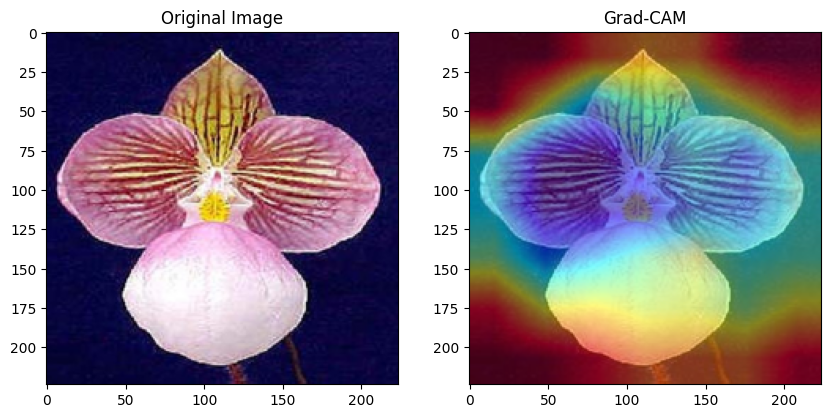

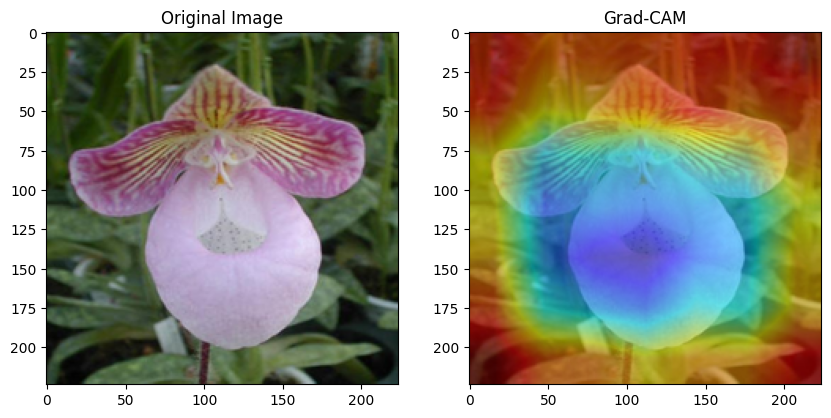

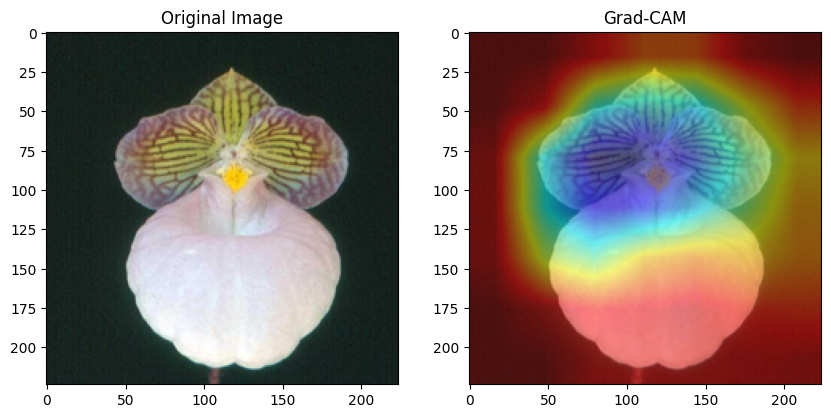

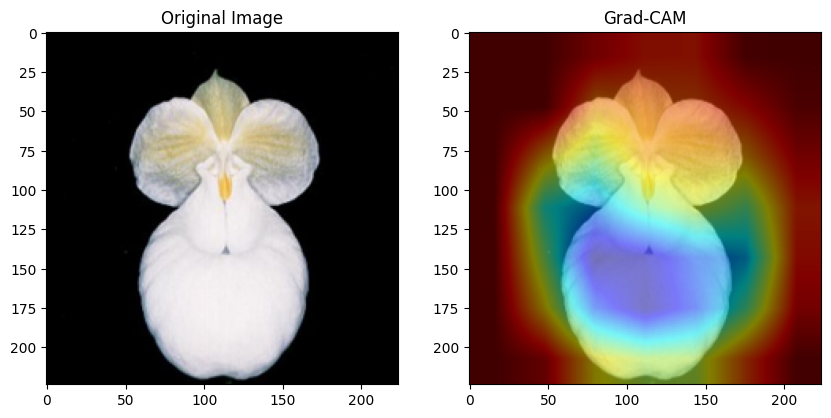

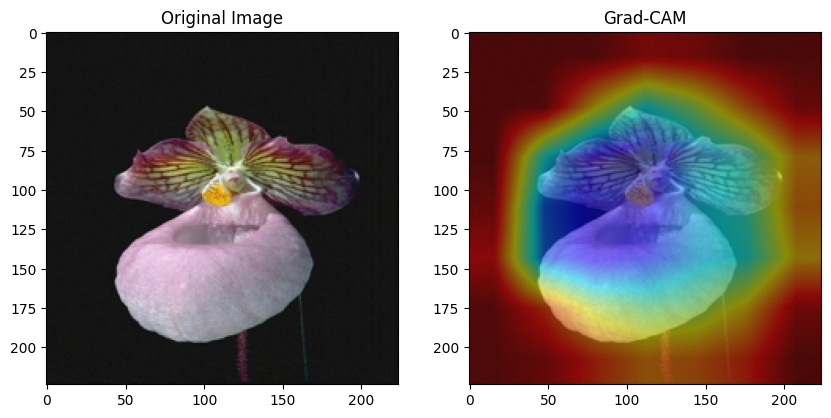

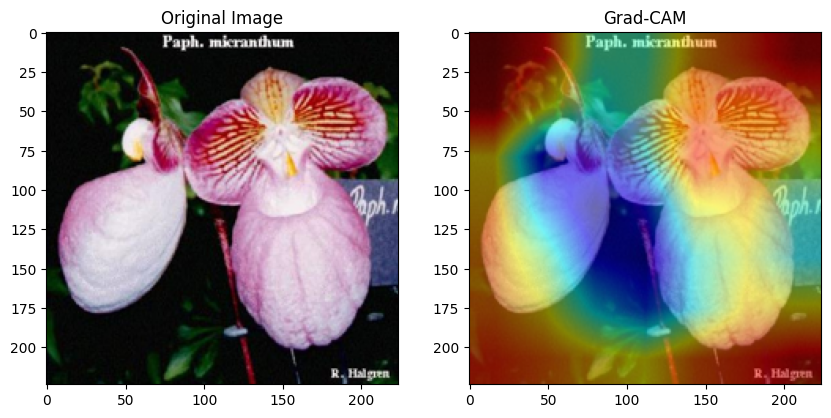

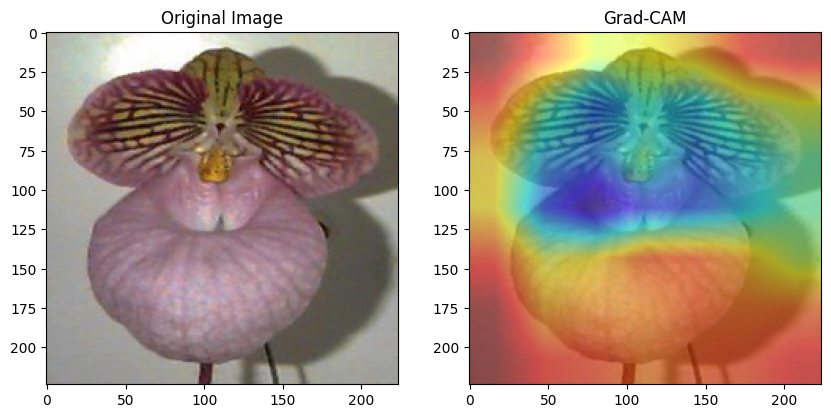

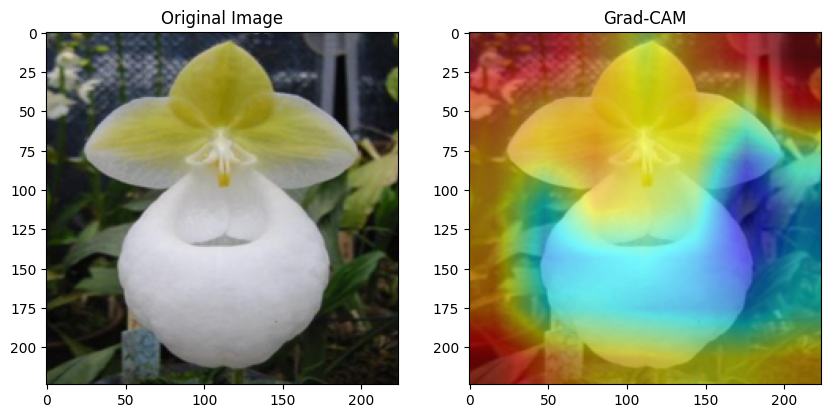

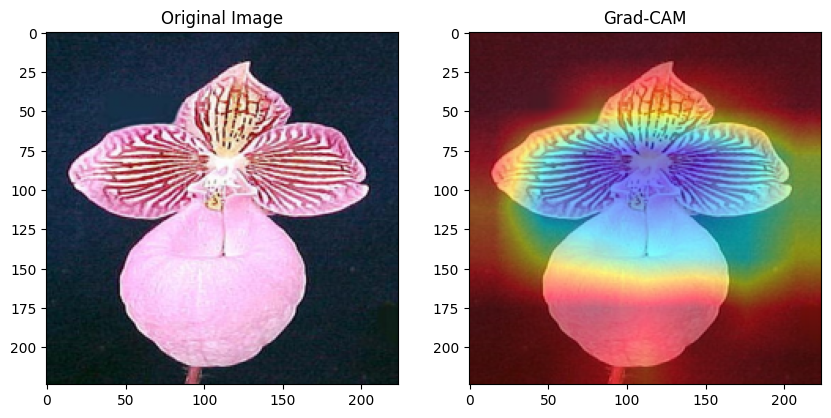

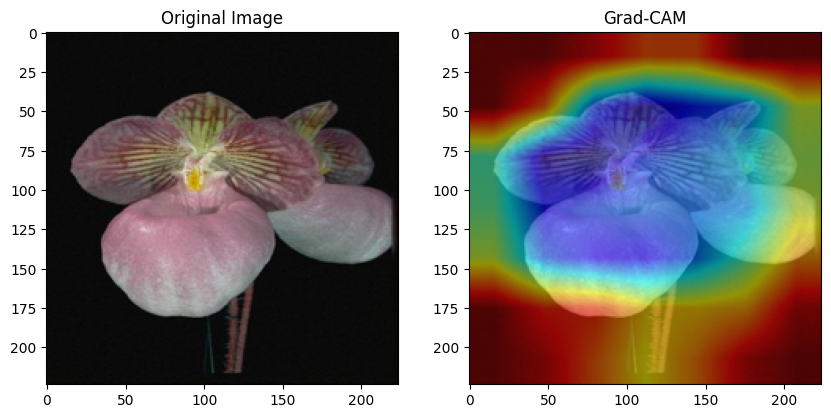

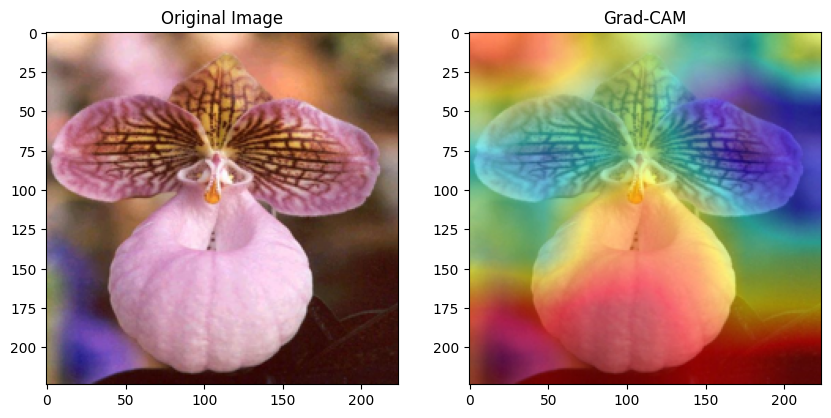

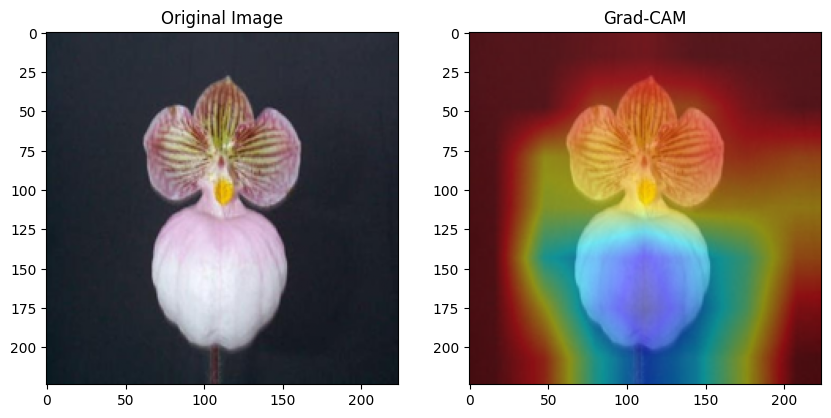

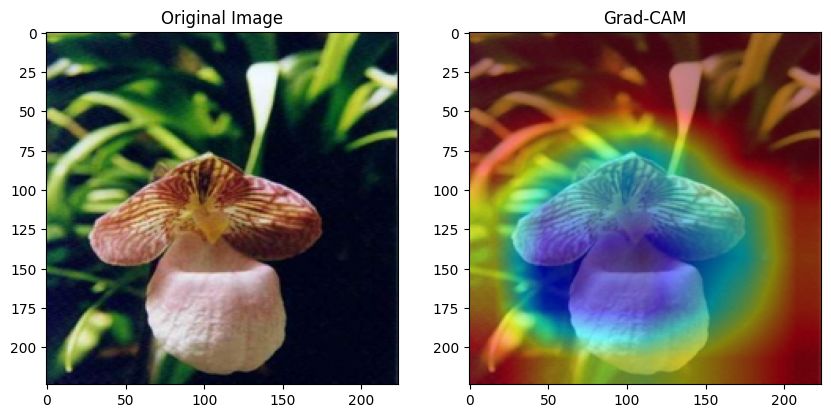

In [9]:
import glob
class GradCAM:
    def __init__(self,model,target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)
    def save_features(self,module,input,output):
        self.features = output
    def save_gradients(self,module,grad_in,grad_out):
        self.gradients = grad_out[0]
    def generate(self,module,target_class):
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0,target_class]
        target.backward()
        weights = torch.mean(self.gradients,dim=[2,3],keepdim =True)
        cam = torch.sum(weights*self.features,dim=1,keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam-np.min(cam))/(np.max(cam) - np.min(cam))
        return cam
model = models.resnet50(pretrained=True)
model.eval()
input_size = (224,224)
target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)
image_folder = "/*.jpg"
image_paths = glob.glob(image_folder)
for i in image_paths:
  input_tensor = preprocess(i,input_size)
  output = model(input_tensor)
  predicted_class = torch.argmax(output).item()
  cam = grad_cam.generate(input_tensor,predicted_class)
  original_image = Image.open(i).convert('RGB')
  original_image = np.array(original_image.resize(input_size)) / 255.0
  cam_image = show_cam_on_image(original_image,cam)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Original Image")
  plt.imshow(original_image)

  plt.subplot(1, 2, 2)
  plt.title("Grad-CAM")
  plt.imshow(cam_image)
  plt.show()
